In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import math
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.densenet import DenseNet121
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from keras import optimizers

# img_path="images/"
img_height=224
img_width=224

Using TensorFlow backend.


In [63]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.densenet import preprocess_input

def normilze_generator(datagen, directory):
    imagenet_mean = np.array([0.485, 0.456, 0.406])
    imagenet_std = np.array([0.229, 0.224, 0.225])
    generator = datagen.flow_from_directory(
        directory,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical')
    for batch_x in generator:
        n_batch_x = [(batch_x[0] - imagenet_mean) / imagenet_std, batch_x[1]]
        yield n_batch_x

train_datagen = ImageDataGenerator(
    rescale=1./255,
    
    preprocessing_function=preprocess_input
)

test_datagen = ImageDataGenerator(
    rescale=1./255,
    
    preprocessing_function=preprocess_input
)

batch_size = 32

# train_generator = normilze_generator (train_datagen, 'images/train')
# validation_generator = normilze_generator (train_datagen, 'images/valid')
# test_generator = normilze_generator (test_datagen, 'images/test')

train_generator = train_datagen.flow_from_directory(
    'images/train',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = train_datagen.flow_from_directory(
    'images/valid',
    target_size=(img_height, img_width),
    batch_size=batch_size, 
    class_mode='categorical')
    
test_generator = test_datagen.flow_from_directory(
    'images/test',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    classes=class_mapping)

Found 104470 images belonging to 15 classes.
Found 0 images belonging to 15 classes.
Found 2043 images belonging to 14 classes.


In [55]:
class_mapping = {'Atelectasis':0,'Cardiomegaly':1,'Effusion':2,'Infiltration':3,'Mass':4,'Nodule':5,'Pneumonia':6,'Pneumothorax':7,'Consolidation':8,'Edema':9,'Emphysema':10,'Fibrosis':11,'Pleural_Thickening':12,'Hernia':13}

In [66]:
test_generator.class_indices.keys()

dict_keys(['Atelectasis', 'Cardiomegaly', 'Effusion', 'Infiltration', 'Mass', 'Nodule', 'Pneumonia', 'Pneumothorax', 'Consolidation', 'Edema', 'Emphysema', 'Fibrosis', 'Pleural_Thickening', 'Hernia'])

#### Base Model ( DenseNet -121)

In [157]:
model = DenseNet121(include_top=True, weights=None, input_shape=(img_width,img_height,3), classes=2)
model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999), metrics=['accuracy'])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_19 (InputLayer)           (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_37 (ZeroPadding2 (None, 230, 230, 3)  0           input_19[0][0]                   
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_37[0][0]          
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
__________________________________________________________________________________________________
conv1/relu

In [141]:
scores = model.evaluate_generator(test_generator, steps=math.ceil(640//batch_size), max_queue_size=10, workers=1, use_multiprocessing=False)
print("Testing data score = Loss: %f, Acc: %.2f" % (scores[0],scores[1]))

Found 640 images belonging to 2 classes.
Testing data score = Loss: 0.693163, Acc: 0.50


#### Base Model ( DenseNet -121, pretrained on Imagenet)

In [185]:
base_model = DenseNet121(include_top=False, weights='imagenet', input_shape=(img_width,img_height,3), pooling="avg")

# adding a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# adding logistic regression
predictions = Dense(2, activation='softmax', name="predictions")(x)

# final model
model = Model(inputs=base_model.input, outputs=predictions)

#setting last 10 layers as trainables
trainable_layer = 10
for layer in model.layers[:-10]:
    layer.trainable=False
for layer in model.layers[-10:]:
    layer.trainable=True
    
model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999), metrics=['accuracy'])    

model.summary()

ValueError: Input 0 is incompatible with layer global_average_pooling2d_6: expected ndim=4, found ndim=2

In [184]:
scores = model.evaluate_generator(test_generator, steps=math.ceil(640//batch_size), max_queue_size=10, workers=1, use_multiprocessing=False)
print("Testing data score = Loss: %f, Acc: %.2f" % (scores[0],scores[1]))

Testing data score = Loss: 0.930893, Acc: 0.50


#### Trained Model

In [163]:
model.load_weights('weights/weights.01-0.63.hdf5')
## best - weights/weights.01-0.63.hdf5 second best - weights.01-0.65.hdf5

In [60]:
model = DenseNet121(include_top=True, weights=None, input_shape=(img_width,img_height,3), classes=14)
model.load_weights('weights/best.h5')
# model.layers.pop()
# x = model.layers[-1].output
# predictions = Dense(2, activation='softmax')(x)
# model = Model(inputs=model.input, outputs=predictions)
model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999), metrics=['accuracy'])    
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_5 (ZeroPadding2D (None, 230, 230, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_5[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
__________________________________________________________________________________________________
conv1/relu

In [65]:
# scores = model.evaluate_generator(validation_generator, steps=validation_generator.n//batch_size, max_queue_size=10, workers=1, use_multiprocessing=False)
# print("Validation data score = Loss: %f, Acc@1: %.2f" % (scores[0],scores[1]))
scores = model.evaluate_generator(test_generator, steps=math.ceil(test_generator.n//batch_size), max_queue_size=10, workers=1, use_multiprocessing=False)
print("Testing data score = Loss: %f, Acc: %.2f" % (scores[0],scores[1]))

Testing data score = Loss: 11.423515, Acc: 0.04


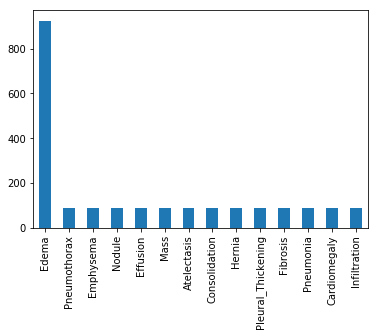

In [67]:
import pandas as pd
mapping = test_generator.class_indices
mapping = dict((v,k) for k,v in mapping.items())
distribution = pd.DataFrame(test_generator.classes,columns=['classes'])
distribution = distribution.replace({"classes":mapping})
distribution['classes'].value_counts().plot('bar')

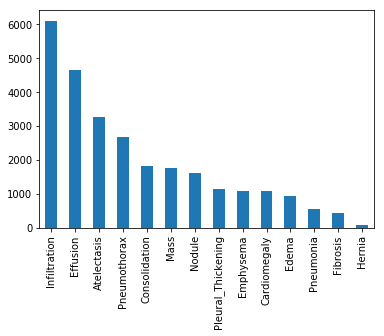

In [53]:
import pandas as pd
mapping = test_generator.class_indices
mapping = dict((v,k) for k,v in mapping.items())
distribution = pd.DataFrame(test_generator.classes,columns=['classes'])
distribution = distribution.replace({"classes":mapping})
distribution['classes'].value_counts().plot('bar')

#### Training model

In [146]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
filepath="weights/weights.{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_loss', patience=500)
#tensorboard = TensorBoard(log_dir='./logs', histogram_freq=0, batch_size=64, write_graph=True, write_grads=False, write_images=True, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None)
callbacks_list = [checkpoint,early_stopping]#,tensorboard]

In [147]:
nb_train_samples = 70608
nb_validation_samples= 1440 
epochs = 10
history = model.fit_generator(
    train_generator,
    steps_per_epoch = math.ceil(nb_train_samples/batch_size), #nb_train_samples/batch_size,
    epochs = epochs,
    validation_data = validation_generator,
    validation_steps = batch_size, #nb_validation_samples/batch_size, #val_batch_size,
    callbacks = callbacks_list,
    verbose = 1)

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
Found 1440 images belonging to 2 classes.
Found 70608 images belonging to 2 classes.
32/32 [==============================] - 245s 8s/step - loss: 0.6903 - acc: 0.5752 - val_loss: 1.1952 - val_acc: 0.4951

Epoch 00001: val_acc improved from -inf to 0.49512, saving model to weights/weights.01-0.50.hdf5
Epoch 2/10
32/32 [==============================] - 201s 6s/step - loss: 0.6779 - acc: 0.5859 - val_loss: 1.2305 - val_acc: 0.5049

Epoch 00002: val_acc improved from 0.49512 to 0.50488, saving model to weights/weights.02-0.50.hdf5
Epoch 3/10
32/32 [==============================] - 203s 6s/step - loss: 0.6583 - acc: 0.6152 - val_loss: 1.2455 - val_acc: 0.4844

Epoch 00003: val_acc did not improve from 0.50488
Epoch 4/10
32/32 [==============================] - 200s 6s/step - loss: 0.6320 - acc: 0.6426 - val_loss: 1.2526 - val_acc: 0.5146

Epoch 00004: val_acc improved from 0.50488 to 0.51465, saving model to weights/weights.04-0.

KeyboardInterrupt: 

In [41]:
preds = model.predict_generator(test_generator, steps=test_generator.n//batch_size, max_queue_size=10, workers=1, use_multiprocessing=False)

(320, 2)

In [73]:
steps = test_generator.n//batch_size
preds = np.zeros((0,2))
y_test = np.zeros((0,2))
step_count = 0
for batch_x, batch_y in test_generator:
    if step_count < steps:
        batch_preds = model.predict(batch_x)
        preds = np.vstack((preds,batch_preds))
        y_test = np.vstack((y_test,batch_y))
        step_count = step_count + 1
    else:
        break
        
print(preds.shape)
print(y_test.shape)

(336, 2)
(336, 2)


In [ ]:
import itertools
from sklearn.metrics import confusion_matrix

y_trues = [np.argmax(ii) for ii in y_test]
y_preds = [np.argmax(ii) for ii in preds]

# https://tatwan.github.io/How-To-Plot-A-Confusion-Matrix-In-Python/    
def plot_binary_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    classNames = classes
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    tick_marks = np.arange(len(classNames))
    plt.xticks(tick_marks, classNames, rotation=45)
    plt.yticks(tick_marks, classNames)
    s = [['TN','FP'], ['FN', 'TP']]
    for i in range(2):
        for j in range(2):
            plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
    
cm = confusion_matrix(y_trues, y_preds)

tn, fp, fn, tp = cm.ravel()
#print(tn, fp, fn, tp)

plt.figure()
plot_binary_confusion_matrix(cm, classes=['Negative','Positive'], title='Confusion matrix, without normalization', cmap=plt.cm.Greens)
plt.show()


In [ ]:
def plot_history(history):
    plt.plot(history.history['loss'],'r--')
    plt.plot(history.history['val_loss'],'b-')
    plt.title('Model Loss')
    plt.legend(['Train Loss', 'Valid Loss'])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show();
    plt.plot(history.history['acc'],'r--')
    plt.plot(history.history['val_acc'],'b-')
    plt.title('Model Accuracy')
    plt.legend(['Train Acc', 'Valid Acc'])
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.show()
    
plot_history(history)

In [ ]:
import bcolz
def save_array(fname, arr): c=bcolz.carray(arr, rootdir=fname, mode='w'); c.flush()
def load_array(fname): return bcolz.open(fname)[:]

def plot_img(img, title, count, cols, plot_axis=False):
    a = fig.add_subplot(1, cols, count)
    # if 'img' is a NumPy array, then it has already been loaded; just show it
    if type(img).__module__ == np.__name__:
        plt.imshow(img)
    else:
        plt.imshow(load_img(img))
    a.set_title(title,fontsize=10)
    if plot_axis is False:
        plt.axis('off')

In [84]:
excel['View Position'].unique()

array(['PA', 'AP'], dtype=object)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


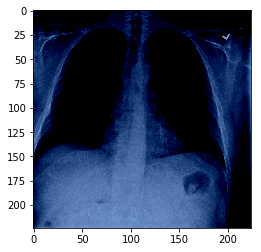

In [89]:
a = test_generator.next()
plt.imshow(a[0][4])

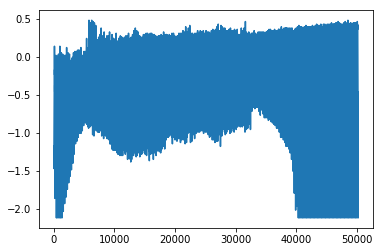

In [93]:
plt.plot(a[0][4][:,:,0].flatten())